# Create figures that show performance of different feature sets

## Figure 3

- Panel A: Confusion matrix for test set performance in real and shuffled models (full feature spaces)
- Panel B: Precision recall curves for all 15 phenotypes
- Panel C: F1 scores

## Supplementary Figure

- Panel A: Confusion matrix for test set performance in real models (Zernike and AreaShape only)
- Panel B: Precision recall curves (Zernike and AreaShape only)
- Panel C: F1 scores (Zernike and AreaShape only)

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))

# Load variables important for plotting (e.g., themes, phenotypes, etc.)
source("themes.r")

Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘patchwork’ was built under R version 4.2.3”


In [2]:
figure_dir <- "figures"
output_main_figure_3 <- file.path(figure_dir, "main_figure_3_multiclass_model_eval.png")
output_sup_figure_subset <- file.path(figure_dir, "supplementary", "subset_featurespace_multiclass_model_eval.png")

In [3]:
# Load confustion matrix data
cm_dir <- file.path("../3.evaluate_model/evaluations/confusion_matrices")
cm_file <- file.path(cm_dir, "compiled_cm_data.tsv")

cm_df <- readr::read_tsv(
    cm_file,
    col_types = readr::cols(
        .default = "c",
        shuffled = "l",
        Count = "d",
        balance_type = "c"
    )
) %>%
    dplyr::select(!...1) %>%
    dplyr::filter(
        balance_type == "balanced",
        dataset_type == "ic"
    ) %>%
    dplyr::group_by(True_Label, data_split, shuffled, balance_type, feature_type) %>%
    dplyr::mutate(
        total_count = sum(Count),
        ratio = Count / total_count
    )

# Reverse order of predicted label for plotting
cm_df$Predicted_Label <-
    factor(cm_df$Predicted_Label, levels = rev(unique(cm_df$Predicted_Label)))

# Order feature types for plotting
cm_df$feature_type <-
    dplyr::recode_factor(cm_df$feature_type, !!!feature_spaces)

print(dim(cm_df))
head(cm_df)

New names:
• `` -> `...1`


[1] 4500   10


True_Label,Predicted_Label,Count,data_split,shuffled,feature_type,balance_type,dataset_type,total_count,ratio
<chr>,<fct>,<dbl>,<chr>,<lgl>,<fct>,<chr>,<chr>,<dbl>,<dbl>
ADCCM,ADCCM,77,train,FALSE,CellProfiler,balanced,ic,81,0.95061728
ADCCM,Anaphase,0,train,FALSE,CellProfiler,balanced,ic,81,0.00000000
ADCCM,Apoptosis,0,train,FALSE,CellProfiler,balanced,ic,81,0.00000000
ADCCM,Binuclear,0,train,FALSE,CellProfiler,balanced,ic,81,0.00000000
ADCCM,Elongated,0,train,FALSE,CellProfiler,balanced,ic,81,0.00000000
ADCCM,Grape,1,train,FALSE,CellProfiler,balanced,ic,81,0.01234568


In [4]:
# Feature spaces to subset
# Note: facet_labels and feature_spaces defined in `themes.r`
focus_feature_spaces <- paste(facet_labels)
focus_feature_spaces

subset_feature_spaces <- paste(feature_spaces[!(paste(feature_spaces) %in% focus_feature_spaces)])
subset_feature_spaces

[1] "CellProfiler" "DeepProfiler" "CP and DP"

[1] "CP Zernike"   "CP AreaShape"

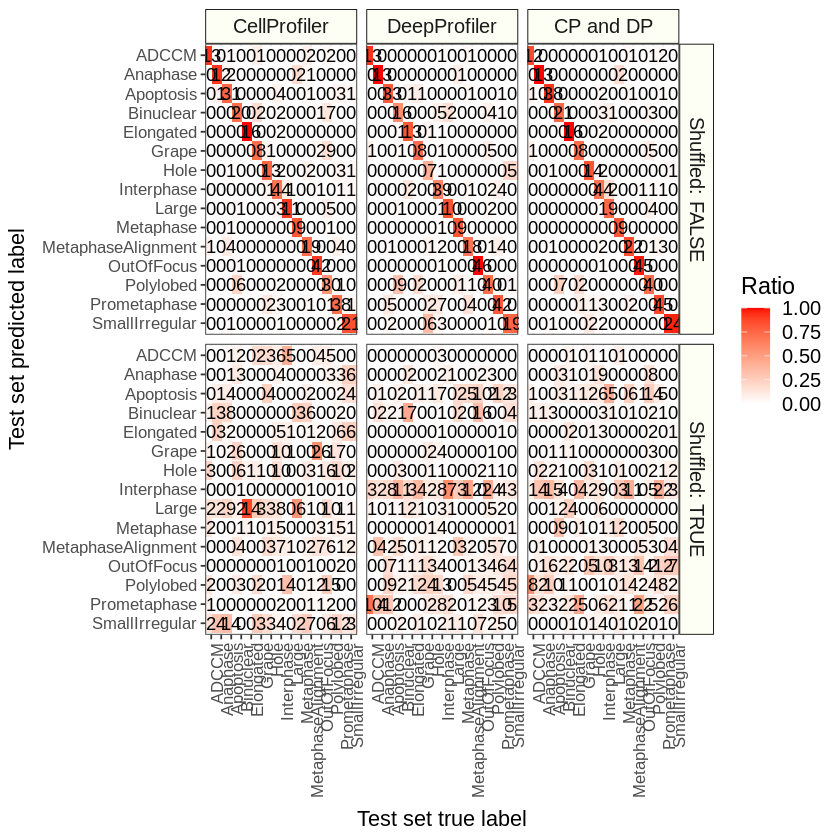

In [5]:
custom_labeller <- function(value) {
  paste("Shuffled:", value)
}

confusion_matrix_gg <- (
    ggplot(
        cm_df %>%
            dplyr::filter(data_split == "test") %>%
            dplyr::filter(feature_type %in% !!focus_feature_spaces),
        aes(x = True_Label, y = Predicted_Label)
    )
    + facet_grid("shuffled~feature_type", labeller = labeller(shuffled = custom_labeller))
    + geom_point(aes(color = ratio), size = 5, shape = 15)
    + geom_text(aes(label = Count))
    + scale_color_gradient("Ratio", low = "white", high = "red")
    + theme_bw()
    + phenotypic_ggplot_theme
    + theme(
        axis.text.x = element_text(angle = 90, hjust = 1, size = 10),
        axis.title = element_text(size = 13),
        axis.text.y = element_text(size = 10),
        strip.text = element_text(size = 12),
        legend.text = element_text(size = 12),
        legend.title = element_text(size = 14),
    )
    + labs(x = "Test set true label", y = "Test set predicted label")
)

confusion_matrix_gg

## Generate precision recall curves

In [6]:
# Load data
results_dir <- file.path(
    "..", "3.evaluate_model", "evaluations", "precision_recall_curves"
)
results_file <- file.path(results_dir, "compiled_class_PR_curves.tsv.gz")

pr_df <- readr::read_tsv(
    results_file,
    col_types = readr::cols(
        .default = "d",
        "Phenotypic_Class" = "c",
        "data_split" = "c",
        "shuffled" = "c",
        "feature_type" = "c",
        "balance_type" = "c",
        "dataset_type" = "c"
    )
) %>%
    dplyr::select(!`...1`) %>%
    dplyr::mutate(feature_type_with_data_split = paste0(feature_type, data_split)) %>%
    dplyr::filter(
        balance_type == "balanced",
        dataset_type == "ic"
    )

# Order feature types for plotting
pr_df$feature_type <-
    dplyr::recode_factor(pr_df$feature_type, !!!feature_spaces)

print(dim(pr_df))
head(pr_df)

New names:
• `` -> `...1`


[1] 429300     10


Phenotypic_Class,PR_Threshold,Precision,Recall,data_split,shuffled,feature_type,balance_type,dataset_type,feature_type_with_data_split
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<chr>,<chr>,<chr>
ADCCM,4.849966e-18,0.03330592,1,train,False,CellProfiler,balanced,ic,CPtrain
ADCCM,3.111641e-15,0.03331962,1,train,False,CellProfiler,balanced,ic,CPtrain
ADCCM,1.286148e-14,0.03333333,1,train,False,CellProfiler,balanced,ic,CPtrain
ADCCM,1.661306e-14,0.03334706,1,train,False,CellProfiler,balanced,ic,CPtrain
ADCCM,3.628374e-14,0.03336079,1,train,False,CellProfiler,balanced,ic,CPtrain
ADCCM,3.644341e-14,0.03337454,1,train,False,CellProfiler,balanced,ic,CPtrain


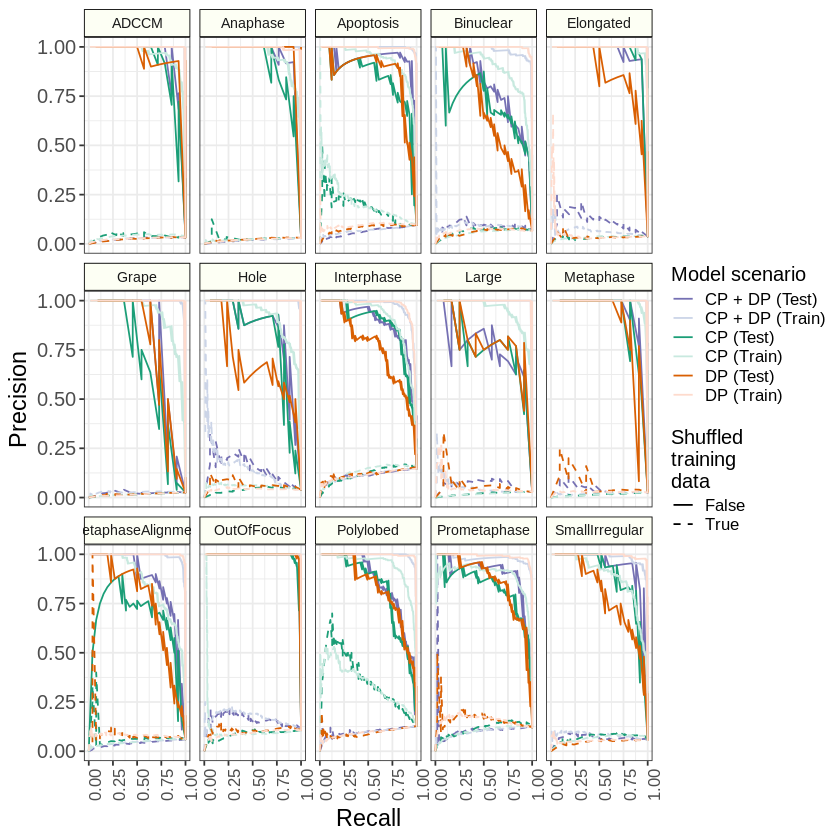

In [7]:
pr_curve_gg <- (
    ggplot(
        pr_df %>%
            dplyr::filter(feature_type %in% !!focus_feature_spaces),
        aes(x = Recall, y = Precision))
    + geom_line(aes(color = feature_type_with_data_split, linetype = shuffled))
    + facet_wrap("~Phenotypic_Class", nrow = 3)
    + theme_bw()
    + xlab("Recall")
    + ylab("Precision")
    + scale_color_manual(
        name = "Model scenario",
        labels = feature_type_with_data_split_labels,
        values = feature_type_with_data_split_colors
    )
    + scale_linetype_manual(
        name = "Shuffled\ntraining\ndata",
        labels = shuffled_labels,
        values = shuffled_linetypes
    )
    + guides(
        color = guide_legend(order = 1),
        linetype = guide_legend(order = 2),
    )
    + phenotypic_ggplot_theme
    # Decrease spacing in legend
    + theme(
        legend.spacing.y = unit(0.1, "cm"),
        legend.box.spacing = unit(0.2, "cm"),
        legend.key.size = unit(0.7, "lines"),
        legend.key.width = unit(1, "lines"),
        axis.text.x = element_text(angle = 90),
        strip.text = element_text(size = 8.5),
        axis.text.y = element_text(size = 12),
        axis.title = element_text(size = 14)
    )
)

pr_curve_gg

## F1 score summary

In [8]:
# Load data
results_dir <- file.path(
    "..", "3.evaluate_model", "evaluations", "F1_scores"
)
results_file <- file.path(results_dir, "compiled_F1_scores.tsv")

f1_score_df <- readr::read_tsv(
    results_file,
    col_types = readr::cols(
        .default = "d",
        "Phenotypic_Class" = "c",
        "data_split" = "c",
        "shuffled" = "c",
        "feature_type" = "c",
        "balance_type" = "c",
        "dataset_type" = "c"
    )
) %>%
    dplyr::select(!`...1`) %>%
    dplyr::mutate(feature_type_with_data_split = paste0(feature_type, data_split)) %>%
    dplyr::filter(
        data_split == "test",
        balance_type == "balanced",
        dataset_type == "ic"
    )

# Order feature types for plotting
f1_score_df$feature_type <-
    dplyr::recode_factor(f1_score_df$feature_type, !!!feature_spaces)

f1_score_df$Phenotypic_Class <-
    dplyr::recode(f1_score_df$Phenotypic_Class, Weighted = "OverallPerformance")

# Reverse order of predicted label for plotting
front_level <- "OverallPerformance"
remaining_levels <- setdiff(unique(f1_score_df$Phenotypic_Class), front_level)
new_order <- c(rev(remaining_levels), front_level)

f1_score_df$Phenotypic_Class <-
    factor(f1_score_df$Phenotypic_Class, levels = new_order)

print(dim(f1_score_df))
head(f1_score_df)

New names:
• `` -> `...1`


[1] 160   8


Phenotypic_Class,F1_Score,data_split,shuffled,feature_type,balance_type,dataset_type,feature_type_with_data_split
<fct>,<dbl>,<chr>,<chr>,<fct>,<chr>,<chr>,<chr>
ADCCM,0.7878788,test,False,CellProfiler,balanced,ic,CPtest
Anaphase,0.8000000,test,False,CellProfiler,balanced,ic,CPtest
Apoptosis,0.7560976,test,False,CellProfiler,balanced,ic,CPtest
Binuclear,0.6666667,test,False,CellProfiler,balanced,ic,CPtest
Elongated,0.9411765,test,False,CellProfiler,balanced,ic,CPtest
Grape,0.5161290,test,False,CellProfiler,balanced,ic,CPtest


In [9]:
# How many of the phenotypic classes are certain feature types the best?
top_scores_df <- f1_score_df %>%
    dplyr::arrange(desc(F1_Score)) %>%
    dplyr::group_by(Phenotypic_Class) %>%
    dplyr::slice(1)

print(table(top_scores_df$feature_type_with_data_split))

top_scores_df


CP_and_DPtest        CPtest        DPtest 
           10             2             4 


Phenotypic_Class,F1_Score,data_split,shuffled,feature_type,balance_type,dataset_type,feature_type_with_data_split
<fct>,<dbl>,<chr>,<chr>,<fct>,<chr>,<chr>,<chr>
SmallIrregular,0.8888889,test,False,CP and DP,balanced,ic,CP_and_DPtest
Prometaphase,0.8653846,test,False,CP and DP,balanced,ic,CP_and_DPtest
Polylobed,0.7692308,test,False,CP and DP,balanced,ic,CP_and_DPtest
OutOfFocus,0.9892473,test,False,DeepProfiler,balanced,ic,DPtest
MetaphaseAlignment,0.8000000,test,False,CP and DP,balanced,ic,CP_and_DPtest
Metaphase,0.9000000,test,False,CP and DP,balanced,ic,CP_and_DPtest
Large,0.7692308,test,False,DeepProfiler,balanced,ic,DPtest
Interphase,0.7857143,test,False,CellProfiler,balanced,ic,CPtest
Hole,0.8000000,test,False,CP and DP,balanced,ic,CP_and_DPtest


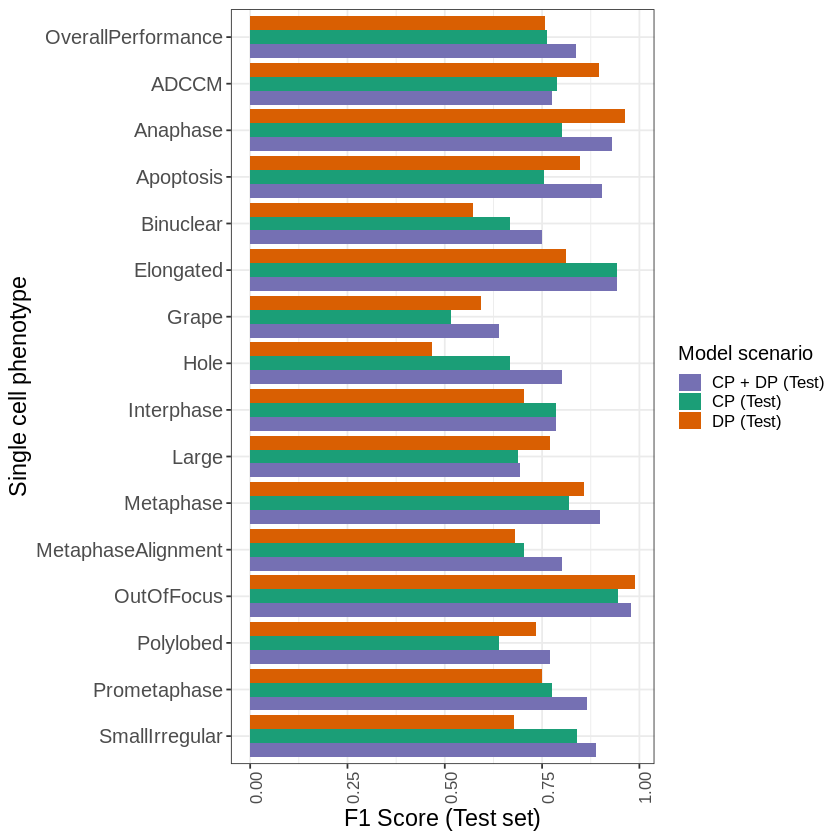

In [10]:
f1_score_gg <- (
    ggplot(
        f1_score_df %>%
            dplyr::filter(feature_type %in% !!focus_feature_spaces),
        aes(x = Phenotypic_Class, y = F1_Score))
    + geom_bar(aes(fill = feature_type_with_data_split), stat = "identity", position = "dodge")
    + theme_bw()
    + xlab("Single cell phenotype")
    + ylab("F1 Score (Test set)")
    + scale_fill_manual(
        name = "Model scenario",
        labels = feature_type_with_data_split_labels,
        values = feature_type_with_data_split_colors
    )
    + phenotypic_ggplot_theme
    # Decrease spacing in legend and rotate text
    + theme(
        legend.spacing.y = unit(0.2, "cm"),
        legend.box.spacing = unit(0.3, "cm"),
        legend.key.size = unit(0.8, "lines"),
        legend.key.width = unit(1, "lines"),
        axis.text.x = element_text(angle = 90),
        axis.text.y = element_text(size = 12),
        axis.title = element_text(size = 14)
    )
    + coord_flip()
)

f1_score_gg

## Compile supplementary figure of feature subset models

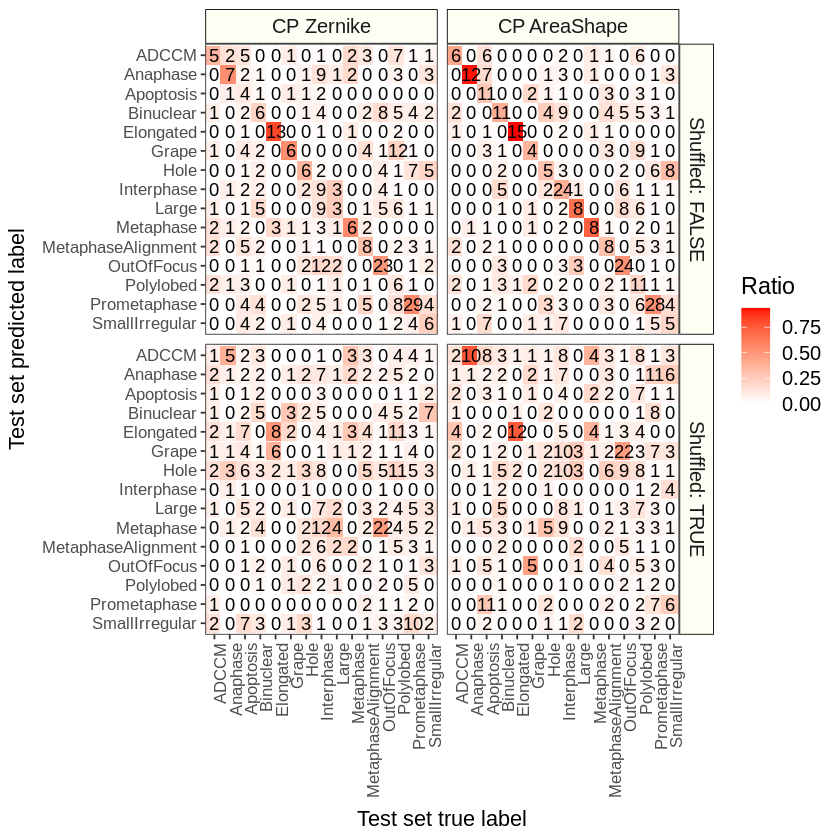

In [11]:
confusion_matrix_subset_gg <- (
    ggplot(
        cm_df %>%
            dplyr::filter(data_split == "test") %>%
            dplyr::filter(feature_type %in% !!subset_feature_spaces),
        aes(x = True_Label, y = Predicted_Label)
    )
    + facet_grid("shuffled~feature_type", labeller = labeller(shuffled = custom_labeller))
    + geom_point(aes(color = ratio), size = 5, shape = 15)
    + geom_text(aes(label = Count))
    + scale_color_gradient("Ratio", low = "white", high = "red")
    + theme_bw()
    + phenotypic_ggplot_theme
    + theme(
        axis.text.x = element_text(angle = 90, hjust = 1, size = 10),
        axis.title = element_text(size = 13),
        axis.text.y = element_text(size = 10),
        strip.text = element_text(size = 12),
        legend.text = element_text(size = 12),
        legend.title = element_text(size = 14),
    )
    + labs(x = "Test set true label", y = "Test set predicted label")
)

confusion_matrix_subset_gg

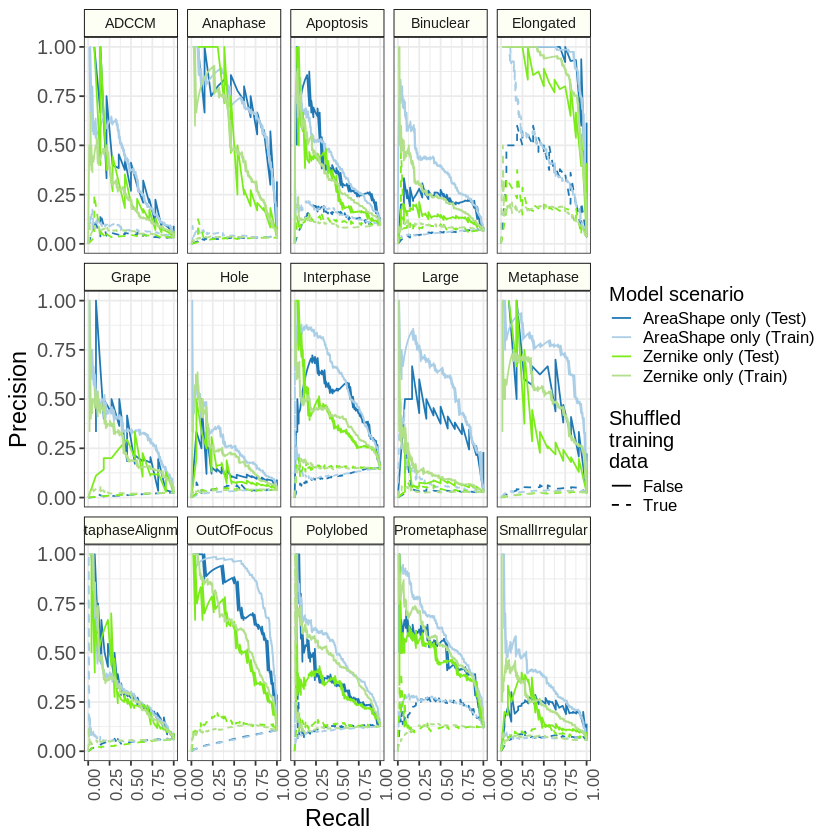

In [12]:
pr_curve_subset_gg <- (
    ggplot(
        pr_df %>%
            dplyr::filter(feature_type %in% !!subset_feature_spaces),
        aes(x = Recall, y = Precision))
    + geom_line(aes(color = feature_type_with_data_split, linetype = shuffled))
    + facet_wrap("~Phenotypic_Class", nrow = 3)
    + theme_bw()
    + xlab("Recall")
    + ylab("Precision")
    + scale_color_manual(
        name = "Model scenario",
        labels = subset_feature_type_with_data_split_labels,
        values = subset_feature_type_with_data_split_colors
    )
    + scale_linetype_manual(
        name = "Shuffled\ntraining\ndata",
        labels = shuffled_labels,
        values = shuffled_linetypes
    )
    + guides(
        color = guide_legend(order = 1),
        linetype = guide_legend(order = 2),
    )
    + phenotypic_ggplot_theme
    # Decrease spacing in legend
    + theme(
        legend.spacing.y = unit(0.1, "cm"),
        legend.box.spacing = unit(0.2, "cm"),
        legend.key.size = unit(0.7, "lines"),
        legend.key.width = unit(1, "lines"),
        axis.text.x = element_text(angle = 90),
        strip.text = element_text(size = 8.5),
        axis.text.y = element_text(size = 12),
        axis.title = element_text(size = 14)
    )
)

pr_curve_subset_gg

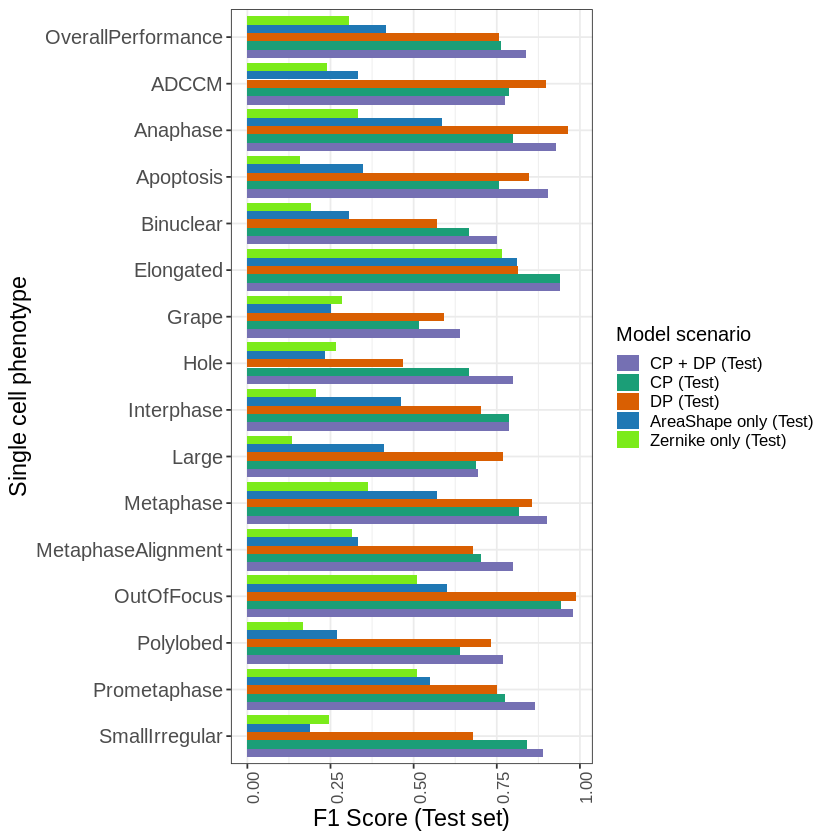

In [13]:
# Reorder test set features for plotting f1 score summary
f1_score_df$feature_type_with_data_split <-
    factor(
        f1_score_df$feature_type_with_data_split,
        levels = c("CP_and_DPtest", "CPtest", "DPtest", "CP_areashape_onlytest", "CP_zernike_onlytest")
    )

f1_score_subset_gg <- (
    ggplot(
        f1_score_df,
        aes(x = Phenotypic_Class, y = F1_Score))
    + geom_bar(aes(fill = feature_type_with_data_split), stat = "identity", position = "dodge")
    + theme_bw()
    + xlab("Single cell phenotype")
    + ylab("F1 Score (Test set)")
    + scale_fill_manual(
        name = "Model scenario",
        labels = c(subset_feature_type_with_data_split_labels, feature_type_with_data_split_labels),
        values = c(subset_feature_type_with_data_split_colors, feature_type_with_data_split_colors)
    )
    + phenotypic_ggplot_theme
    # Decrease spacing in legend and rotate text
    + theme(
        legend.spacing.y = unit(0.2, "cm"),
        legend.box.spacing = unit(0.3, "cm"),
        legend.key.size = unit(0.8, "lines"),
        legend.key.width = unit(1, "lines"),
        axis.text.x = element_text(angle = 90),
        axis.text.y = element_text(size = 12),
        axis.title = element_text(size = 14)
    )
    + coord_flip()
)

f1_score_subset_gg

## Compile full figure 3

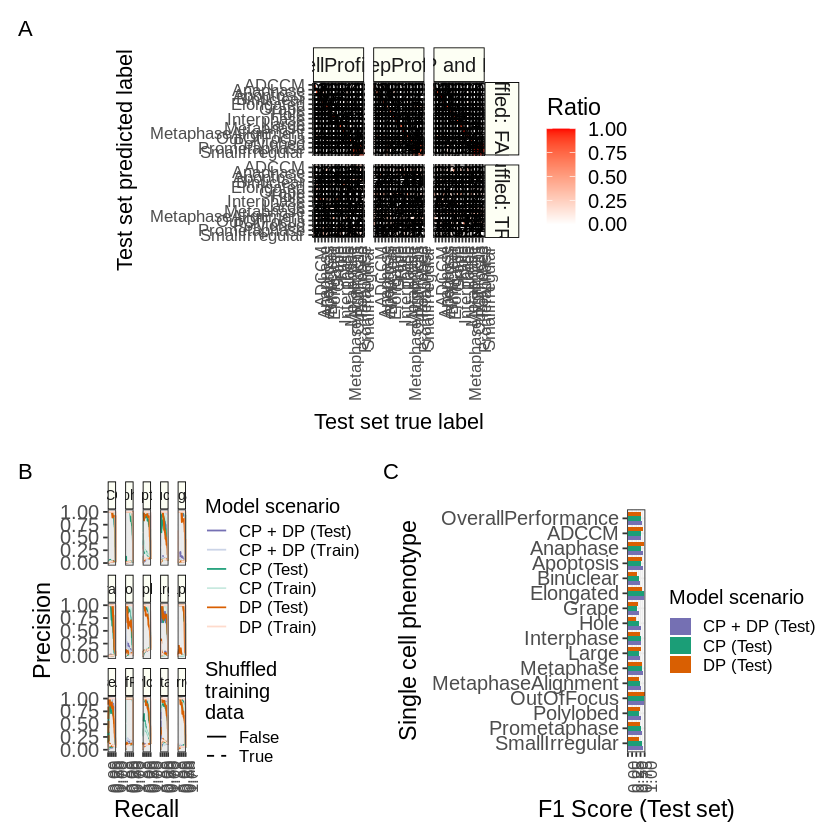

In [14]:
bottom_plot <- (
    pr_curve_gg | 
    f1_score_gg
) + plot_layout(widths = c(3, 0.7))

fig_3_gg <- (
    wrap_elements(confusion_matrix_gg) /
    bottom_plot
) + plot_annotation(tag_levels = "A") + plot_layout(heights = c(1, 0.6))

ggsave(output_main_figure_3, dpi = 500, height = 14, width = 14)

fig_3_gg

## Compile supplementary figure

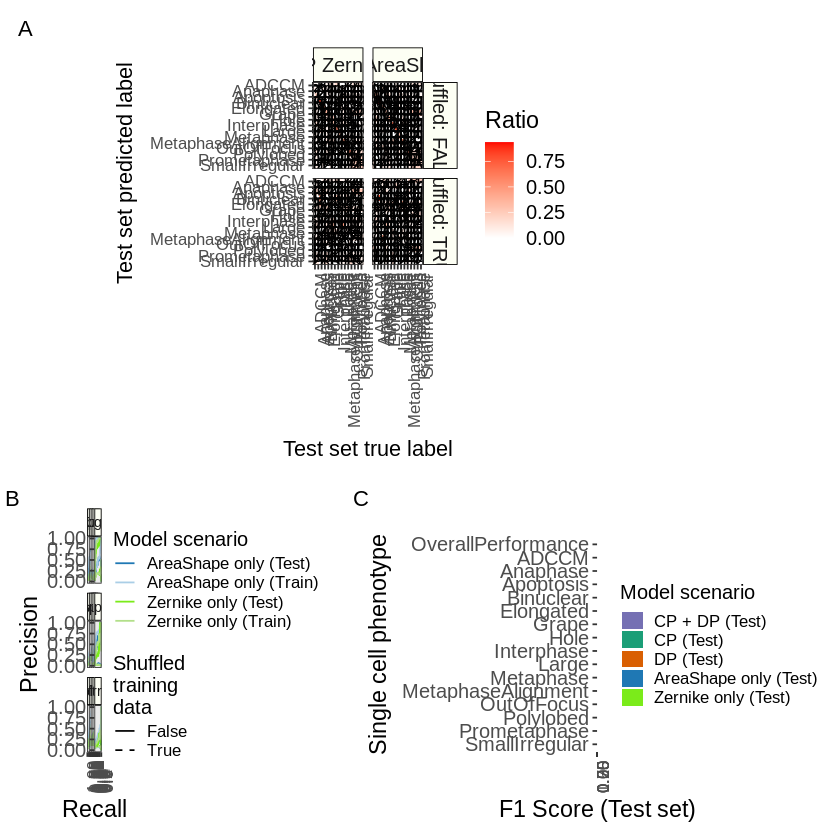

In [15]:
bottom_plot <- (
    pr_curve_subset_gg | 
    f1_score_subset_gg
) + plot_layout(widths = c(3, 0.7))

sup_fig_3_gg <- (
    wrap_elements(confusion_matrix_subset_gg) /
    bottom_plot
) + plot_annotation(tag_levels = "A") + plot_layout(heights = c(1, 0.5))

ggsave(output_sup_figure_subset, dpi = 500, height = 14, width = 14)

sup_fig_3_gg